# LSTM
The purpose of this notebook is to use XGBoost for predicting hourly bike demand by station.

In [3]:
# Load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import datetime

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_squared_log_error, accuracy_score, make_scorer, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, PowerTransformer
from sklearn import datasets, svm

import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras import backend as K

In [4]:
# Import data
df = pd.read_csv('data/bike_temp_fe.csv')
df['start_datetime'] = pd.to_datetime(df['start_datetime'])
df.head()

,num_trips,start_datetime,start_station_id,start_station_longitude,start_station_latitude,avg_trip_duration,num_trips_1hr,num_trips_2hr,num_trips_3hr,num_trips_4hr,...,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,month_sin,month_cos,is_am_peak,is_pm_peak
0,0.0,2019-05-08,3183,-74.033459,40.716247,0.0,0.0,2.0,3.0,2.0,...,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,-0.974928,-0.222521,False,False
1,0.0,2019-05-08,3184,-74.033552,40.714145,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,-0.974928,-0.222521,False,False
2,0.0,2019-05-08,3185,-74.043845,40.717732,0.0,1.0,1.0,0.0,2.0,...,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,-0.974928,-0.222521,False,False
3,0.0,2019-05-08,3186,-74.043117,40.719586,0.0,0.0,4.0,8.0,8.0,...,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,-0.974928,-0.222521,False,False
4,0.0,2019-05-08,3187,-74.038051,40.721124,0.0,0.0,1.0,2.0,0.0,...,0.0,1.0,0.866025,-0.5,0.998717,-0.050649,-0.974928,-0.222521,False,False


## Structure Dataset

In [5]:
# Split data into X, y
# X does not need previous counts, as it is included in LSTM
X = df.iloc[0:,1:]
X.drop(columns=['num_trips_1hr', 'num_trips_2hr', 'num_trips_3hr', 'num_trips_4hr', 'num_trips_5hr', 'num_trips_6hr', 'num_trips_24hr', 'num_trips_48hr', 'num_trips_week'], inplace=True)

y = df.iloc[:,0:3]
y.reindex(columns=['start_datetime', 'start_station_id', 'num_trips'])

best_split = 0.30
X_train_init, X_test_init, y_train_init, y_test_init = train_test_split(X, y, test_size=best_split, shuffle=False)

In [6]:
# Creates time-series data using subsequences
def create_dataset(X, y, time_steps):
    Xs, ys = [], []
    
    # Pivot X so there is one timestep for all combined station/variable combos
    X = X.pivot(index='start_datetime', columns='start_station_id', values=X.columns[2:])
    X.columns = ['%s%s' % (b, '|%s' % a if b else '') for a, b in X.columns]
    X.reset_index(inplace=True)
    # Pivot y so there is one timestep for all combined stations
    y = y.pivot(index='start_datetime', columns='start_station_id', values=['num_trips'])
    y.columns = ['%s%s' % (b, '|%s' % a if b else '') for a, b in y.columns]
    y.reset_index(inplace=True)
    
    # Determine total number of hours
    min_datetime = X.start_datetime.min()
    max_datetime = X.start_datetime.max()
    diff = max_datetime - min_datetime
    total_hours = int(((diff.days)*24) + (diff.seconds / 3600))

    i = 0
    for i in range(total_hours - time_steps):
        start_datetime = min_datetime + pd.Timedelta(hours=i)
        end_datetime = start_datetime + pd.Timedelta(hours=time_steps)
        # Get all X values >= start_datetime and < end_datetime
        vX = X.loc[(X['start_datetime'] >= start_datetime) & (X['start_datetime'] < end_datetime)]
        vX.drop(columns=['start_datetime'], inplace=True)
        Xs.append(vX.values)
        
        # Append sequence to ys
        vy = y.loc[(y['start_datetime'] == end_datetime)]
        vy.drop(columns=['start_datetime'], inplace=True)
        ys.append(vy.values[0])

        i += 1
        
    return np.asarray(Xs).astype(np.float32), np.asarray(ys).astype(np.float32)
    return Xs, ys

In [7]:
X_train, y_train = create_dataset(X_train_init, y_train_init, 72)
X_test, y_test = create_dataset(X_test_init, y_test_init, 72)

/Users/michaelgysel/.pyenv/versions/3.7.2/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [51]:
X_train.shape

(1355, 72, 1484)

In [8]:
y_train.shape

(1355, 53)

In [9]:
X_test.shape

(539, 72, 1484)

In [10]:
y_test.shape

(539, 53)

## Setup LSTM Model

In [8]:
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    
    return score

rmse_scorer = make_scorer(rmse, greater_is_better=False)

def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))
        
def make_predictions_print_results(y, preds):
    # Results
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    R2 = r2_score(y, preds)
    print("\n")
    print(f"RMSE of preds, y_test: {rmse}")
    print(f"MAE of preds, y_test: {mae}")
    print(f"R-Squared of preds, y_test: {R2}")
    print("\n\n")

In [9]:
# RMSE and build_model functions

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def build_model(shape, hidden_nodes=900, optimizer='adam', activation='sigmoid', num_layers=1):
    # Sequential allows us to stack multiple layers on top of each other
    model = keras.Sequential()
    model.add(
      # First layer is bidirectional layer
      #keras.layers.Bidirectional(
        # In bidirectional layer, put in LSTM layer
        keras.layers.LSTM(
          # Dimensions of inner cells
          units=hidden_nodes, 
          # input_shape of neural network
          input_shape=(shape[1], shape[2]),
          activation=activation
        )
      #)
    )
    # Add dropout layer to penalize more complex models
    model.add(keras.layers.Dropout(rate=0.2))
    # Output layer with 53 neurons as we are predicting 53 stations
    model.add(keras.layers.Dense(53))
    model.compile(loss=root_mean_squared_error, optimizer=optimizer)
    
    return model

## Train LSTM Model

#### Testing Normalization/Standardization

Lets test the impact of scaling the data using RobustScaler, MinMaxScaler, StandardScaler, and PowerTransformer

In [77]:
scalers = [[RobustScaler(), RobustScaler()], [MinMaxScaler(), MinMaxScaler()], [StandardScaler(), StandardScaler()], [PowerTransformer(), PowerTransformer()]]
scaler_names = ["RobustScaler", "MinMaxScaler", "StandardScaler", "PowerTransformer"]

i = 0
for scaler in scalers:
    print(f"SCALER: {scaler_names[i]}", )

    # Scale data with RobustScaler
    f_transformer = scaler[0]
    cnt_transformer = scaler[1]

    X_train_scaler = X_train_init
    y_train_scaler = y_train_init
    X_test_scaler = X_test_init
    y_test_scaler = y_test_init

    f_columns = ['start_station_latitude', 'start_station_longitude', 'avg_trip_duration', 'avg_daily_wind_speed', 'precipitation', 'snowfall', 'snow_depth', 'temp_max', 'temp_min', 'day_of_week', 'day_of_month', 'month', 'hour']
    cnt_columns = ['num_trips']
    f_transformer = f_transformer.fit(X_train_scaler[f_columns].to_numpy())
    cnt_transformer = cnt_transformer.fit(y_train_scaler[cnt_columns].to_numpy())

    X_train_scaler.loc[:,f_columns] = f_transformer.transform(X_train_scaler[f_columns].to_numpy())
    y_train_scaler.loc[:,cnt_columns] = cnt_transformer.transform(y_train_scaler[cnt_columns].to_numpy())
    X_test_scaler.loc[:,f_columns] = f_transformer.transform(X_test_scaler[f_columns].to_numpy())


    # Create dataset
    X_train_scaled, y_train_scaled = create_dataset(X_train_scaler, y_train_scaler, 72)
    X_test_scaled, y_test_scaled = create_dataset(X_test_scaler, y_test_scaler, 72)


    # Train model
    grid_model = KerasRegressor(build_fn=build_model)

    parameters = {
        'validation_split': [0.3],
        'shape': [X_train_scaled.shape]
    }
    cv = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=4, scoring=rmse_scorer)
    cv.fit(X_train_scaled, y_train_scaled)
    print_results(cv)


    # Make predictions
    preds = cv.predict(X_test_scaled)
    preds_reshape = cnt_transformer.inverse_transform(preds.reshape(-1,1))
    preds_reshape[preds_reshape < 0] = 0
    y_test_reshape = y_test.reshape(-1,1)

    print("\n")
    make_predictions_print_results(y_test_reshape, preds_reshape)
    
    i += 1

SCALER: RobustScaler


/Users/michaelgysel/.pyenv/versions/3.7.2/lib/python3.7/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/Users/michaelgysel/.pyenv/versions/3.7.2/lib/python3.7/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/Users/michaelgysel/.pyenv/versions/3.7.2/lib/python3.7/site-packages/pandas/core/indexing.py:1738: Se

30/30 [==============================] - 48s 2s/step - loss: 0.5181 - val_loss: 0.4569
BEST PARAMS: {'shape': (1355, 72, 1484), 'validation_split': 0.3}

-0.455 (+/-0.033) for {'shape': (1355, 72, 1484), 'validation_split': 0.3}


RMSE of preds, y_test: 3.0187909603118896
MAE of preds, y_test: 1.584825038909912
R-Squared of preds, y_test: -0.24046402259589117



SCALER: MinMaxScaler


/Users/michaelgysel/.pyenv/versions/3.7.2/lib/python3.7/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/Users/michaelgysel/.pyenv/versions/3.7.2/lib/python3.7/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/Users/michaelgysel/.pyenv/versions/3.7.2/lib/python3.7/site-packages/pandas/core/indexing.py:1738: Se

30/30 [==============================] - 42s 1s/step - loss: 0.4352 - val_loss: 0.3615
BEST PARAMS: {'shape': (1355, 72, 1484), 'validation_split': 0.3}

-0.361 (+/-0.011) for {'shape': (1355, 72, 1484), 'validation_split': 0.3}


RMSE of preds, y_test: 2.7745723724365234
MAE of preds, y_test: 1.1610445976257324
R-Squared of preds, y_test: -0.04787677818451663



SCALER: StandardScaler


/Users/michaelgysel/.pyenv/versions/3.7.2/lib/python3.7/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/Users/michaelgysel/.pyenv/versions/3.7.2/lib/python3.7/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/Users/michaelgysel/.pyenv/versions/3.7.2/lib/python3.7/site-packages/pandas/core/indexing.py:1738: Se

30/30 [==============================] - 41s 1s/step - loss: 0.8710 - val_loss: 0.8488
BEST PARAMS: {'shape': (1355, 72, 1484), 'validation_split': 0.3}

-0.827 (+/-0.037) for {'shape': (1355, 72, 1484), 'validation_split': 0.3}


RMSE of preds, y_test: 2.7676167488098145
MAE of preds, y_test: 1.1805617809295654
R-Squared of preds, y_test: -0.042629462542380425



SCALER: PowerTransformer


/Users/michaelgysel/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/Users/michaelgysel/.pyenv/versions/3.7.2/lib/python3.7/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/Users/michaelgysel/.pyenv/versions/3.7.2/lib/python3.7/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

30/30 [==============================] - 39s 1s/step - loss: 0.8828 - val_loss: 0.8592
BEST PARAMS: {'shape': (1355, 72, 1484), 'validation_split': 0.3}

-0.838 (+/-0.032) for {'shape': (1355, 72, 1484), 'validation_split': 0.3}


RMSE of preds, y_test: 5.005363464355469
MAE of preds, y_test: 1.745841145515442
R-Squared of preds, y_test: -2.410274789364711





StandardScaler reduced RMSE the most at 2.76. Now lets compare this to an unscaled model

In [9]:
# Train model
grid_model = KerasRegressor(build_fn=build_model)

parameters = {
    'validation_split': [0.3],
    'shape': [X_train.shape]
}
cv = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=4, scoring=rmse_scorer)
cv.fit(X_train, y_train)
print_results(cv)

# Make predictions
preds = cv.predict(X_test)
preds_reshape = preds.reshape(-1,1)
preds_reshape[preds_reshape < 0] = 0
y_test_reshape = y_test.reshape(-1,1)

# Results
make_predictions_print_results(y_test_reshape, preds_reshape)

30/30 [==============================] - 40s 1s/step - loss: 2.0178 - val_loss: 1.9955
BEST PARAMS: {'shape': (1355, 72, 1484), 'validation_split': 0.3}

-1.998 (+/-0.14) for {'shape': (1355, 72, 1484), 'validation_split': 0.3}


RMSE of preds, y_test: 2.3899917602539062
MAE of preds, y_test: 1.086916446685791
R-Squared of preds, y_test: 0.22248114380534056





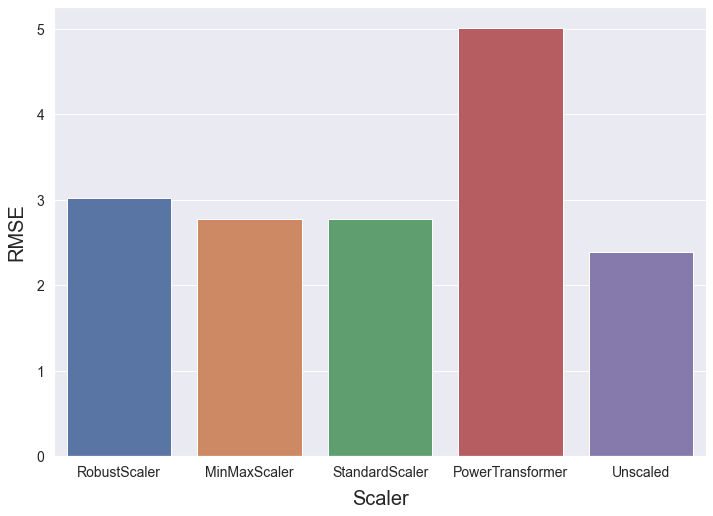

In [27]:
data = {
    'Scaler': ['RobustScaler', 'MinMaxScaler', 'StandardScaler', 'PowerTransformer', 'Unscaled'],
    'RMSE': [3.019, 2.775, 2.777, 5.005, 2.390]
}
test_size_RMSE = pd.DataFrame(data)

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
p = sns.barplot(data=test_size_RMSE, x='Scaler', y='RMSE')
p.set_xlabel('Scaler', fontsize=20, labelpad=10)
p.set_ylabel('RMSE', fontsize=20, labelpad=10)
p.tick_params(labelsize=14)

fig = p.get_figure()
fig.savefig('figs/LSTM-ScalervsRMSE.png', bbox_inches='tight')

The unscaled data resulted in an RMSE of 2.39. Because the unscaled data resulted in a lower RMSE than any of the scalers, the data was left unscaled.

In [8]:
X_train, y_train = create_dataset(X_train_init, y_train_init, 72)
X_test, y_test = create_dataset(X_test_init, y_test_init, 72)

In [103]:
X_train.shape

(1355, 72, 1484)

In [104]:
y_train.shape

(1355, 53)

In [105]:
X_test.shape

(539, 72, 1484)

In [106]:
y_test.shape

(539, 53)

#### Validation Split

In [16]:
grid_model = KerasRegressor(build_fn=build_model)

parameters = {
    'validation_split': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'shape': [X_train.shape]
}
cv = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=4, scoring=rmse_scorer)
cv.fit(X_train, y_train)

print_results(cv)

39/39 [==============================] - 42s 1s/step - loss: 2.0253 - val_loss: 1.9161
BEST PARAMS: {'shape': (1355, 72, 1484), 'validation_split': 0.1}

-1.98 (+/-0.141) for {'shape': (1355, 72, 1484), 'validation_split': 0.1}
-1.983 (+/-0.124) for {'shape': (1355, 72, 1484), 'validation_split': 0.2}
-1.991 (+/-0.137) for {'shape': (1355, 72, 1484), 'validation_split': 0.3}
-2.004 (+/-0.157) for {'shape': (1355, 72, 1484), 'validation_split': 0.4}
-2.027 (+/-0.152) for {'shape': (1355, 72, 1484), 'validation_split': 0.5}
-2.042 (+/-0.136) for {'shape': (1355, 72, 1484), 'validation_split': 0.6}
-2.069 (+/-0.144) for {'shape': (1355, 72, 1484), 'validation_split': 0.7}
-2.12 (+/-0.161) for {'shape': (1355, 72, 1484), 'validation_split': 0.8}
-2.238 (+/-0.194) for {'shape': (1355, 72, 1484), 'validation_split': 0.9}


The best validation split is 0.1, but lets use 0.3 as it attains nearly the same RMSE and will better prevent overfitting of the model.

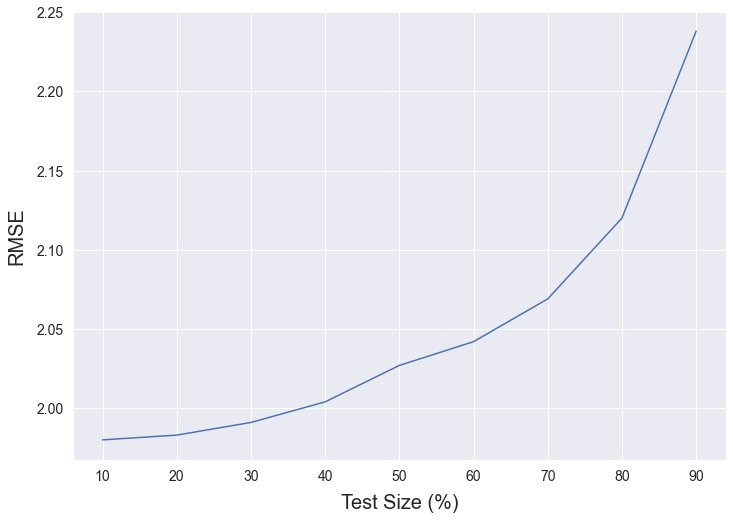

In [27]:
data = {
    'test_size': [10, 20, 30, 40, 50, 60, 70, 80, 90],
    'RMSE': [1.98, 1.983, 1.991, 2.004, 2.027, 2.042, 2.069, 2.12, 2.238]
}
test_size_RMSE = pd.DataFrame(data)

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
p = sns.lineplot(data=test_size_RMSE, x='test_size', y='RMSE')
p.set_xlabel('Test Size (%)', fontsize=20, labelpad=10)
p.set_ylabel('RMSE', fontsize=20, labelpad=10)
p.tick_params(labelsize=14)

fig = p.get_figure()
fig.savefig('figs/LSTM-TestSizevsRMSE.png', bbox_inches='tight')

#### Testing k for k-fold validation

In [18]:
grid_model = KerasRegressor(build_fn=build_model)

k_values = [2, 4, 6, 8, 10, 12, 14]
for k in k_values:
    parameters = {
        'validation_split': [0.3],
        'shape': [X_train.shape]
    }
    cv = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=k, scoring=rmse_scorer)
    cv.fit(X_train, y_train)
    
    print(f"K VALUE: {k}", )
    print_results(cv)
    
    # Make predictions
    preds = cv.predict(X_test)
    preds_reshape = preds.reshape(-1,1)
    preds_reshape[preds_reshape < 0] = 0
    y_test_reshape = y_test.reshape(-1,1)
    make_predictions_print_results(y_test_reshape, preds_reshape)
    print("\n")

30/30 [==============================] - 37s 1s/step - loss: 2.0378 - val_loss: 2.0059
K VALUE: 2
BEST PARAMS: {'shape': (1355, 72, 1484), 'validation_split': 0.3}

-2.043 (+/-0.082) for {'shape': (1355, 72, 1484), 'validation_split': 0.3}


RMSE of preds, y_test: 2.402873992919922
MAE of preds, y_test: 1.0986850261688232
R-Squared of preds, y_test: 0.214076740987443





30/30 [==============================] - 38s 1s/step - loss: 2.0199 - val_loss: 2.0049
K VALUE: 4
BEST PARAMS: {'shape': (1355, 72, 1484), 'validation_split': 0.3}

-1.987 (+/-0.132) for {'shape': (1355, 72, 1484), 'validation_split': 0.3}


RMSE of preds, y_test: 2.4148194789886475
MAE of preds, y_test: 1.0470194816589355
R-Squared of preds, y_test: 0.2062433138568288





30/30 [==============================] - 38s 1s/step - loss: 2.0306 - val_loss: 2.0002
K VALUE: 6
BEST PARAMS: {'shape': (1355, 72, 1484), 'validation_split': 0.3}

-1.985 (+/-0.278) for {'shape': (1355, 72, 1484), 'validation_split': 0.3}


RMSE o

It appears the k-value of 14 reduces the RMSE the most. We will use a k-value of 4 due to computational limiations.

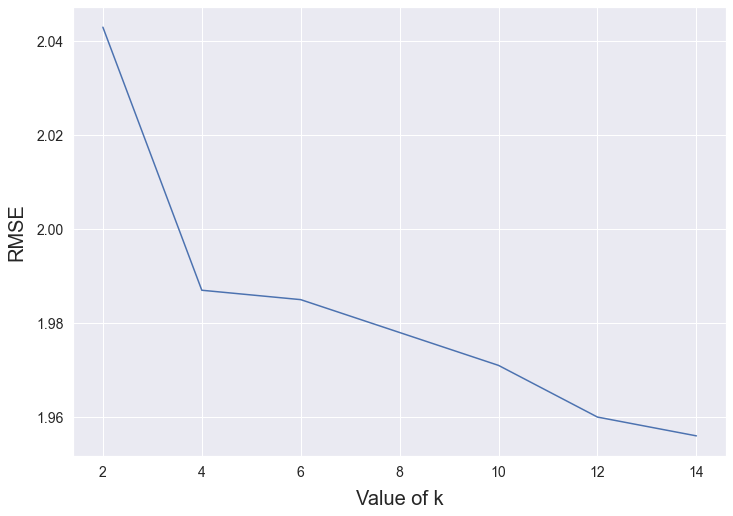

In [29]:
data = {
    'k_value': [2, 4, 6, 8, 10, 12, 14],
    'RMSE': [2.043, 1.987, 1.985, 1.978, 1.971, 1.96, 1.956]
}
k_value_RMSE = pd.DataFrame(data)

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
p = sns.lineplot(data=k_value_RMSE, x='k_value', y='RMSE')
p.set_xlabel('Value of k', fontsize=20, labelpad=10)
p.set_ylabel('RMSE', fontsize=20, labelpad=10)
p.tick_params(labelsize=14)

fig = p.get_figure()
fig.savefig('figs/LSTM-kvsRMSE.png', bbox_inches='tight')

#### Number of Timesteps

In [19]:
# Lets test out the impact the number of timesteps has 
# day, two days, three days, week, two weeks
timesteps = [1, 3, 6, 10, 24, 48, 72, 168, 336]
training_data = {}

for timestep in timesteps:
    this_X_train, this_y_train = create_dataset(X_train_init, y_train_init, timestep)
    training_data[timestep] = [this_X_train, this_y_train]

/Users/michaelgysel/.pyenv/versions/3.7.2/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# Train on each individual dataset
for timestep in timesteps:
    train_data = training_data[timestep]
    
    # Create model
    grid_model = KerasRegressor(build_fn=build_model)
    parameters = {
        'validation_split': [0.3],
        'shape': [train_data[0].shape]
    }
    cv = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=4, scoring=rmse_scorer)
    
    print(f"Training on {timestep} hours of data")

    cv.fit(train_data[0], train_data[1])
    print_results(cv)
    print("\n\n")

Training on 1 hours of data
32/32 [==============================] - 3s 49ms/step - loss: 2.0750 - val_loss: 2.0092
BEST PARAMS: {'shape': (1426, 1, 1484), 'validation_split': 0.3}

-2.034 (+/-0.168) for {'shape': (1426, 1, 1484), 'validation_split': 0.3}



Training on 3 hours of data
32/32 [==============================] - 4s 106ms/step - loss: 2.0628 - val_loss: 1.9910
BEST PARAMS: {'shape': (1424, 3, 1484), 'validation_split': 0.3}

-2.024 (+/-0.155) for {'shape': (1424, 3, 1484), 'validation_split': 0.3}



Training on 6 hours of data
32/32 [==============================] - 6s 170ms/step - loss: 2.0662 - val_loss: 2.0013
BEST PARAMS: {'shape': (1421, 6, 1484), 'validation_split': 0.3}

-2.017 (+/-0.166) for {'shape': (1421, 6, 1484), 'validation_split': 0.3}



Training on 10 hours of data
31/31 [==============================] - 9s 269ms/step - loss: 2.0539 - val_loss: 1.9911
BEST PARAMS: {'shape': (1417, 10, 1484), 'validation_split': 0.3}

-2.013 (+/-0.145) for {'shape': (141

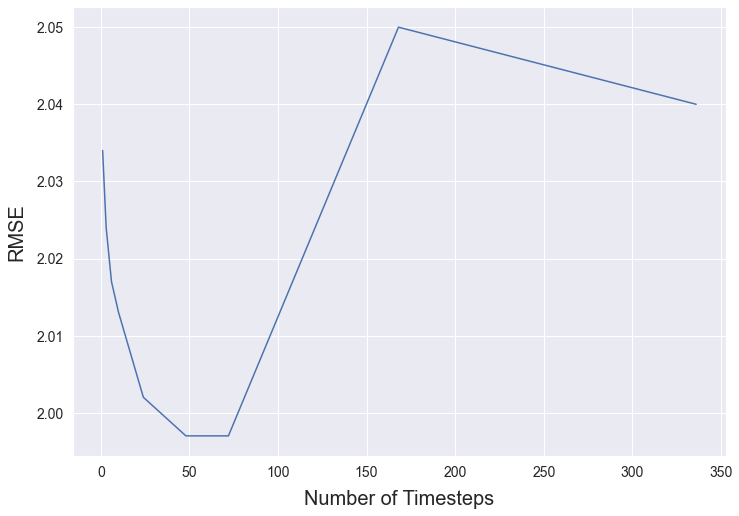

In [28]:
data = {
    'num_timesteps': [1, 3, 6, 10, 24, 48, 72, 168, 336],
    'RMSE': [2.034, 2.024, 2.017, 2.013, 2.002, 1.997, 1.997, 2.05, 2.04]
}
test_size_RMSE = pd.DataFrame(data)

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
p = sns.lineplot(data=test_size_RMSE, x='num_timesteps', y='RMSE')
p.set_xlabel('Number of Timesteps', fontsize=20, labelpad=10)
p.set_ylabel('RMSE', fontsize=20, labelpad=10)
p.tick_params(labelsize=14)

fig = p.get_figure()
fig.savefig('figs/LSTM-NumTimestepsvsRMSE.png', bbox_inches='tight')

48 and 72 hours result in approximately the same RMSE. Lets use 72 hour timesteps.

In [10]:
X_train, y_train = create_dataset(X_train_init, y_train_init, 72)
X_test, y_test = create_dataset(X_test_init, y_test_init, 72)

In [47]:
X_train.shape

(1355, 72, 1484)

#### Number of Hidden Nodes (wider network)

In [11]:
# A rule of thumb for the number of hidden nodes is
# N_h = 2/3 * (N_i + N_o)
# N_ᵢ (number of input neurons) = 1484. 
# N_o (number of output neurons)= 53.
ni = X_train.shape[2]
no = X_train.shape[1]
hidden_nodes = int((2/3) * (ni + no))
hidden_nodes

1037

In [12]:
# Lets test a range of hidden_nodes

# NOTE: build_fn must be a callable
grid_model = KerasRegressor(build_fn=build_model)

parameters = {
    'shape': [X_train.shape],
    'validation_split': [0.3],
    'hidden_nodes': [53, 250, 500, 850, 1037, 1272, 1484]
}
cv = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=4, scoring=rmse_scorer)
cv.fit(X_train, y_train)

print_results(cv)

30/30 [==============================] - 109s 4s/step - loss: 1.9796 - val_loss: 1.9699
BEST PARAMS: {'hidden_nodes': 1484, 'shape': (1355, 72, 1484), 'validation_split': 0.3}

-2.332 (+/-0.18) for {'hidden_nodes': 53, 'shape': (1355, 72, 1484), 'validation_split': 0.3}
-2.112 (+/-0.155) for {'hidden_nodes': 250, 'shape': (1355, 72, 1484), 'validation_split': 0.3}
-2.033 (+/-0.136) for {'hidden_nodes': 500, 'shape': (1355, 72, 1484), 'validation_split': 0.3}
-1.997 (+/-0.126) for {'hidden_nodes': 850, 'shape': (1355, 72, 1484), 'validation_split': 0.3}
-1.99 (+/-0.148) for {'hidden_nodes': 1037, 'shape': (1355, 72, 1484), 'validation_split': 0.3}
-1.976 (+/-0.121) for {'hidden_nodes': 1272, 'shape': (1355, 72, 1484), 'validation_split': 0.3}
-1.972 (+/-0.14) for {'hidden_nodes': 1484, 'shape': (1355, 72, 1484), 'validation_split': 0.3}


In [13]:
print_results(cv)

BEST PARAMS: {'hidden_nodes': 1484, 'shape': (1355, 72, 1484), 'validation_split': 0.3}

-2.332 (+/-0.18) for {'hidden_nodes': 53, 'shape': (1355, 72, 1484), 'validation_split': 0.3}
-2.112 (+/-0.155) for {'hidden_nodes': 250, 'shape': (1355, 72, 1484), 'validation_split': 0.3}
-2.033 (+/-0.136) for {'hidden_nodes': 500, 'shape': (1355, 72, 1484), 'validation_split': 0.3}
-1.997 (+/-0.126) for {'hidden_nodes': 850, 'shape': (1355, 72, 1484), 'validation_split': 0.3}
-1.99 (+/-0.148) for {'hidden_nodes': 1037, 'shape': (1355, 72, 1484), 'validation_split': 0.3}
-1.976 (+/-0.121) for {'hidden_nodes': 1272, 'shape': (1355, 72, 1484), 'validation_split': 0.3}
-1.972 (+/-0.14) for {'hidden_nodes': 1484, 'shape': (1355, 72, 1484), 'validation_split': 0.3}


The best performing hidden_nodes is 1484, so we will continue with that parameter.

#### Number of Layers (Deeper network)

In [14]:
def build_model_2_layers(shape, hidden_nodes=1484, optimizer='adam', activation='sigmoid'):
    # Sequential allows us to stack multiple layers on top of each other
    model = keras.Sequential()
    model.add(
        # In bidirectional layer, put in LSTM layer
        keras.layers.LSTM(
          # Dimensions of inner cells
          units=hidden_nodes, 
          # input_shape of neural network
          input_shape=(shape[1], shape[2]),
          activation=activation,
          return_sequences=True
        )
    )
    model.add(
        keras.layers.LSTM(
          # Dimensions of inner cells
          units=int(hidden_nodes/2), 
          # input_shape of neural network
          input_shape=(shape[1], shape[2]),
          activation=activation
        )
      #)
    )
    # Add dropout layer to penalize more complex models
    model.add(keras.layers.Dropout(rate=0.2))
    # Output layer with 53 neurons as we are predicting 53 stations
    model.add(keras.layers.Dense(53))
    model.compile(loss=root_mean_squared_error, optimizer=optimizer)
    
    return model

def build_model_3_layers(shape, hidden_nodes=1484, optimizer='adam', activation='sigmoid'):
    # Sequential allows us to stack multiple layers on top of each other
    model = keras.Sequential()
    model.add(
        # In bidirectional layer, put in LSTM layer
        keras.layers.LSTM(
          # Dimensions of inner cells
          units=hidden_nodes, 
          # input_shape of neural network
          input_shape=(shape[1], shape[2]),
          activation=activation,
          return_sequences=True
        )
    )
    model.add(
        # In bidirectional layer, put in LSTM layer
        keras.layers.LSTM(
          # Dimensions of inner cells
          units=int(hidden_nodes/2), 
          # input_shape of neural network
          input_shape=(shape[1], shape[2]),
          activation=activation,
          return_sequences=True
        )
    )
    model.add(
        keras.layers.LSTM(
          # Dimensions of inner cells
          units=int(hidden_nodes/4), 
          # input_shape of neural network
          input_shape=(shape[1], shape[2]),
          activation=activation
        )
      #)
    )
    # Add dropout layer to penalize more complex models
    model.add(keras.layers.Dropout(rate=0.2))
    # Output layer with 53 neurons as we are predicting 53 stations
    model.add(keras.layers.Dense(53))
    model.compile(loss=root_mean_squared_error, optimizer=optimizer)
    
    return model

In [15]:
# Lets test if 1, 2, or 3 LSTM layers produces a better model


parameters = {
    'shape': [X_train.shape],
    'validation_split': [0.3],
    'hidden_nodes': [1484]
}

print("1 LSTM layer results")
grid_model = KerasRegressor(build_fn=build_model)
cv = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=4, scoring=rmse_scorer)
cv.fit(X_train, y_train)
print_results(cv)
print("\n\n")

print("2 LSTM layer results")
grid_model = KerasRegressor(build_fn=build_model_2_layers)
cv = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=4, scoring=rmse_scorer)
cv.fit(X_train, y_train)
print_results(cv)
print("\n\n")

print("3 LSTM layer results")
grid_model = KerasRegressor(build_fn=build_model_3_layers)
cv = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=4, scoring=rmse_scorer)
cv.fit(X_train, y_train)
print_results(cv)
print("\n\n")

1 LSTM layer results
30/30 [==============================] - 113s 4s/step - loss: 1.9994 - val_loss: 1.9890
BEST PARAMS: {'hidden_nodes': 1484, 'shape': (1355, 72, 1484), 'validation_split': 0.3}

-1.979 (+/-0.137) for {'hidden_nodes': 1484, 'shape': (1355, 72, 1484), 'validation_split': 0.3}



2 LSTM layer results
30/30 [==============================] - 151s 5s/step - loss: 1.9779 - val_loss: 1.9411
BEST PARAMS: {'hidden_nodes': 1484, 'shape': (1355, 72, 1484), 'validation_split': 0.3}

-1.975 (+/-0.103) for {'hidden_nodes': 1484, 'shape': (1355, 72, 1484), 'validation_split': 0.3}



3 LSTM layer results
30/30 [==============================] - 169s 6s/step - loss: 2.0630 - val_loss: 2.0406
BEST PARAMS: {'hidden_nodes': 1484, 'shape': (1355, 72, 1484), 'validation_split': 0.3}

-2.089 (+/-0.151) for {'hidden_nodes': 1484, 'shape': (1355, 72, 1484), 'validation_split': 0.3}





1 and 2 LSTM layers perform approximately the same. Let's use the single layer model as it runs faster.

#### Bidirectional LSTM Layer?

In [16]:
# DEFINE MODEL
def build_model_bidirectional(shape, hidden_nodes=1484, optimizer='adam', activation='sigmoid', num_layers=1):
    # Sequential allows us to stack multiple layers on top of each other
    model = keras.Sequential()
    model.add(
      # First layer is bidirectional layer
      keras.layers.Bidirectional(
        # In bidirectional layer, put in LSTM layer
        keras.layers.LSTM(
          # Dimensions of inner cells
          units=hidden_nodes, 
          # input_shape of neural network
          input_shape=(shape[1], shape[2]),
          activation=activation
        )
      )
    )
    # Add dropout layer to penalize more complex models
    model.add(keras.layers.Dropout(rate=0.2))
    # Output layer with 53 neurons as we are predicting 53 stations
    model.add(keras.layers.Dense(53))
    model.compile(loss=root_mean_squared_error, optimizer=optimizer)
    
    return model

In [17]:
parameters = {
    'shape': [X_train.shape],
    'validation_split': [0.3],
    'hidden_nodes': [1484]
}

print("Bidirectional LSTM Layer results")
grid_model = KerasRegressor(build_fn=build_model_bidirectional)
cv = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=4, scoring=rmse_scorer)
cv.fit(X_train, y_train)
print_results(cv)
print("\n\n")

Bidirectional LSTM Layer results
30/30 [==============================] - 247s 8s/step - loss: 1.9908 - val_loss: 1.9371
BEST PARAMS: {'hidden_nodes': 1484, 'shape': (1355, 72, 1484), 'validation_split': 0.3}

-1.958 (+/-0.128) for {'hidden_nodes': 1484, 'shape': (1355, 72, 1484), 'validation_split': 0.3}





The bidirectional layer appears to slightly improve results. Lets continue with the unidirectional layer as it reduces computational time. 

#### Activation Function

In [18]:
# Activation function
grid_model = KerasRegressor(build_fn=build_model_bidirectional)

parameters = {
    'shape': [X_train.shape],
    'validation_split': [0.3],
    'hidden_nodes': [1484],
    'activation': ['sigmoid', 'tanh']
}
cv = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=4, scoring=rmse_scorer)
cv.fit(X_train, y_train)

print_results(cv)

30/30 [==============================] - 214s 7s/step - loss: 1.9727 - val_loss: 1.9619
BEST PARAMS: {'activation': 'sigmoid', 'hidden_nodes': 1484, 'shape': (1355, 72, 1484), 'validation_split': 0.3}

-1.959 (+/-0.127) for {'activation': 'sigmoid', 'hidden_nodes': 1484, 'shape': (1355, 72, 1484), 'validation_split': 0.3}
-1.974 (+/-0.14) for {'activation': 'tanh', 'hidden_nodes': 1484, 'shape': (1355, 72, 1484), 'validation_split': 0.3}


The sigmoid activation function produces the best results.

#### Optimizer

In [19]:
parameters = {
    'shape': [X_train.shape],
    'validation_split': [0.3],
    'hidden_nodes': [1484],
    'activation': ['sigmoid'],
    'optimizer': ['adam', 'Adadelta', 'SGD']
}
cv = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=4, scoring=rmse_scorer)
cv.fit(X_train, y_train)

print_results(cv)

30/30 [==============================] - 227s 7s/step - loss: 2.0147 - val_loss: 1.9663
BEST PARAMS: {'activation': 'sigmoid', 'hidden_nodes': 1484, 'optimizer': 'adam', 'shape': (1355, 72, 1484), 'validation_split': 0.3}

-1.96 (+/-0.118) for {'activation': 'sigmoid', 'hidden_nodes': 1484, 'optimizer': 'adam', 'shape': (1355, 72, 1484), 'validation_split': 0.3}
-2.581 (+/-0.27) for {'activation': 'sigmoid', 'hidden_nodes': 1484, 'optimizer': 'Adadelta', 'shape': (1355, 72, 1484), 'validation_split': 0.3}
-2.187 (+/-0.215) for {'activation': 'sigmoid', 'hidden_nodes': 1484, 'optimizer': 'SGD', 'shape': (1355, 72, 1484), 'validation_split': 0.3}


The best optimizer is Adam.

#### Number of epochs

In [47]:
# NOTE: build_fn must be a callable
grid_model = KerasRegressor(build_fn=build_model)

parameters = {
    'shape': [X_train.shape],
    'validation_split': [0.3],
    'hidden_nodes': [1484],
    'activation': ['sigmoid'],
    'optimizer': ['adam'],
    'epochs' : [5, 10, 20, 50, 100],
}
cv = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=4, scoring=rmse_scorer)
cv.fit(X_train, y_train)
print_results(cv)

Epoch 1/5
30/30 [==============================] - 10s 273ms/step - loss: 2.2237 - val_loss: 2.0512
Epoch 2/5
30/30 [==============================] - 7s 233ms/step - loss: 2.1805 - val_loss: 2.0485
Epoch 3/5
30/30 [==============================] - 8s 252ms/step - loss: 2.1809 - val_loss: 2.0467
Epoch 4/5
30/30 [==============================] - 7s 246ms/step - loss: 2.1806 - val_loss: 2.0445
Epoch 5/5
30/30 [==============================] - 7s 246ms/step - loss: 2.1754 - val_loss: 2.0469
Epoch 1/5
30/30 [==============================] - 9s 265ms/step - loss: 2.1641 - val_loss: 2.0508
Epoch 2/5
30/30 [==============================] - 8s 265ms/step - loss: 2.1077 - val_loss: 2.0457
Epoch 3/5
30/30 [==============================] - 8s 261ms/step - loss: 2.1224 - val_loss: 2.0443
Epoch 4/5
30/30 [==============================] - 9s 303ms/step - loss: 2.1080 - val_loss: 2.0455
Epoch 5/5
30/30 [==============================] - 8s 263ms/step - loss: 2.1093 - val_loss: 2.0429
Epoch 1/5

Epoch 3/20
30/30 [==============================] - 9s 304ms/step - loss: 2.1065 - val_loss: 2.0446
Epoch 4/20
30/30 [==============================] - 9s 311ms/step - loss: 2.1177 - val_loss: 2.0452
Epoch 5/20
30/30 [==============================] - 9s 305ms/step - loss: 2.1049 - val_loss: 2.0449
Epoch 6/20
30/30 [==============================] - 9s 307ms/step - loss: 2.1056 - val_loss: 2.0458
Epoch 7/20
30/30 [==============================] - 10s 316ms/step - loss: 2.1154 - val_loss: 2.0423
Epoch 8/20
30/30 [==============================] - 9s 308ms/step - loss: 2.0894 - val_loss: 2.0477
Epoch 9/20
30/30 [==============================] - 9s 298ms/step - loss: 2.1062 - val_loss: 2.0438
Epoch 10/20
30/30 [==============================] - 9s 300ms/step - loss: 2.1013 - val_loss: 2.0450
Epoch 11/20
30/30 [==============================] - 9s 309ms/step - loss: 2.1002 - val_loss: 2.0432
Epoch 12/20
30/30 [==============================] - 9s 303ms/step - loss: 2.1033 - val_loss: 2.0

30/30 [==============================] - 8s 251ms/step - loss: 2.0870 - val_loss: 2.0492
Epoch 6/50
30/30 [==============================] - 8s 255ms/step - loss: 2.0790 - val_loss: 2.0434
Epoch 7/50
30/30 [==============================] - 8s 258ms/step - loss: 2.0837 - val_loss: 2.0418
Epoch 8/50
30/30 [==============================] - 8s 257ms/step - loss: 2.0691 - val_loss: 2.0433
Epoch 9/50
30/30 [==============================] - 8s 254ms/step - loss: 2.0809 - val_loss: 2.0437
Epoch 10/50
30/30 [==============================] - 8s 255ms/step - loss: 2.0812 - val_loss: 2.0418
Epoch 11/50
30/30 [==============================] - 7s 248ms/step - loss: 2.0691 - val_loss: 2.0450
Epoch 12/50
30/30 [==============================] - 8s 254ms/step - loss: 2.0791 - val_loss: 2.0422
Epoch 13/50
30/30 [==============================] - 7s 247ms/step - loss: 2.0738 - val_loss: 2.0435
Epoch 14/50
30/30 [==============================] - 8s 254ms/step - loss: 2.0759 - val_loss: 2.0438
Epoch 

30/30 [==============================] - 8s 262ms/step - loss: 2.1567 - val_loss: 2.0444
Epoch 67/100
30/30 [==============================] - 8s 252ms/step - loss: 2.1516 - val_loss: 2.0446
Epoch 68/100
30/30 [==============================] - 7s 250ms/step - loss: 2.1475 - val_loss: 2.0431
Epoch 69/100
30/30 [==============================] - 7s 248ms/step - loss: 2.1417 - val_loss: 2.0441
Epoch 70/100
30/30 [==============================] - 7s 244ms/step - loss: 2.1523 - val_loss: 2.0449
Epoch 71/100
30/30 [==============================] - 8s 254ms/step - loss: 2.1456 - val_loss: 2.0435
Epoch 72/100
30/30 [==============================] - 8s 255ms/step - loss: 2.1546 - val_loss: 2.0438
Epoch 73/100
30/30 [==============================] - 8s 254ms/step - loss: 2.1490 - val_loss: 2.0421
Epoch 74/100
30/30 [==============================] - 8s 251ms/step - loss: 2.1413 - val_loss: 2.0438
Epoch 75/100
30/30 [==============================] - 7s 247ms/step - loss: 2.1509 - val_loss: 

30/30 [==============================] - 7s 242ms/step - loss: 2.0768 - val_loss: 2.0425
Epoch 27/100
30/30 [==============================] - 7s 238ms/step - loss: 2.0701 - val_loss: 2.0436
Epoch 28/100
30/30 [==============================] - 7s 237ms/step - loss: 2.0659 - val_loss: 2.0424
Epoch 29/100
30/30 [==============================] - 7s 241ms/step - loss: 2.0625 - val_loss: 2.0419
Epoch 30/100
30/30 [==============================] - 7s 240ms/step - loss: 2.0683 - val_loss: 2.0443
Epoch 31/100
30/30 [==============================] - 7s 239ms/step - loss: 2.0694 - val_loss: 2.0432
Epoch 32/100
30/30 [==============================] - 8s 252ms/step - loss: 2.0714 - val_loss: 2.0451
Epoch 33/100
30/30 [==============================] - 7s 232ms/step - loss: 2.0733 - val_loss: 2.0418
Epoch 34/100
30/30 [==============================] - 7s 235ms/step - loss: 2.0631 - val_loss: 2.0428
Epoch 35/100
30/30 [==============================] - 7s 244ms/step - loss: 2.0646 - val_loss: 

30/30 [==============================] - 7s 241ms/step - loss: 2.0404 - val_loss: 2.2738
Epoch 87/100
30/30 [==============================] - 7s 244ms/step - loss: 2.0483 - val_loss: 2.2682
Epoch 88/100
30/30 [==============================] - 7s 242ms/step - loss: 2.0377 - val_loss: 2.2728
Epoch 89/100
30/30 [==============================] - 7s 238ms/step - loss: 2.0586 - val_loss: 2.2697
Epoch 90/100
30/30 [==============================] - 7s 241ms/step - loss: 2.0407 - val_loss: 2.2687
Epoch 91/100
30/30 [==============================] - 7s 235ms/step - loss: 2.0491 - val_loss: 2.2713
Epoch 92/100
30/30 [==============================] - 7s 239ms/step - loss: 2.0464 - val_loss: 2.2693
Epoch 93/100
30/30 [==============================] - 7s 235ms/step - loss: 2.0489 - val_loss: 2.2713
Epoch 94/100
30/30 [==============================] - 7s 240ms/step - loss: 2.0505 - val_loss: 2.2696
Epoch 95/100
30/30 [==============================] - 7s 236ms/step - loss: 2.0458 - val_loss: 

Using 5 epochs reduces the RMSE the most.

### Final Model

In [20]:
# NOTE: build_fn must be a callable
grid_model = KerasRegressor(build_fn=build_model)

parameters = {
    'shape': [X_train.shape],
    'validation_split': [0.3],
    'hidden_nodes': [1484],
    'activation': ['sigmoid'],
    'optimizer': ['adam'],
    'epochs' : [5],
}
cv = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=4, scoring=rmse_scorer)
cv.fit(X_train, y_train)
print_results(cv)

Epoch 1/5
23/23 [==============================] - 81s 3s/step - loss: 2.0006 - val_loss: 2.0809
Epoch 2/5
23/23 [==============================] - 80s 3s/step - loss: 1.8651 - val_loss: 2.0669
Epoch 3/5
23/23 [==============================] - 82s 4s/step - loss: 1.8524 - val_loss: 2.0226
Epoch 4/5
23/23 [==============================] - 78s 3s/step - loss: 1.8416 - val_loss: 2.0252
Epoch 5/5
23/23 [==============================] - 78s 3s/step - loss: 1.8099 - val_loss: 2.0072
Epoch 1/5
23/23 [==============================] - 76s 3s/step - loss: 2.0056 - val_loss: 2.0679
Epoch 2/5
23/23 [==============================] - 74s 3s/step - loss: 1.8461 - val_loss: 2.0312
Epoch 3/5
23/23 [==============================] - 76s 3s/step - loss: 1.8332 - val_loss: 2.0271
Epoch 4/5
23/23 [==============================] - 75s 3s/step - loss: 1.8109 - val_loss: 2.0231
Epoch 5/5
23/23 [==============================] - 75s 3s/step - loss: 1.7887 - val_loss: 2.0288
Epoch 1/5
23/23 [=============

In [10]:
# NOTE: build_fn must be a callable
grid_model = KerasRegressor(build_fn=build_model)

parameters = {
    'shape': [X_train.shape],
    'validation_split': [0.3],
    'hidden_nodes': [1272],
    'activation': ['sigmoid'],
    'optimizer': ['adam'],
    'epochs' : [5],
}
cv = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=4, scoring=rmse_scorer)
cv.fit(X_train, y_train)
print_results(cv)

Epoch 1/5
23/23 [==============================] - 61s 3s/step - loss: 2.0213 - val_loss: 2.0796
Epoch 2/5
23/23 [==============================] - 61s 3s/step - loss: 1.8613 - val_loss: 2.0440
Epoch 3/5
23/23 [==============================] - 62s 3s/step - loss: 1.8580 - val_loss: 2.0232
Epoch 4/5
23/23 [==============================] - 58s 3s/step - loss: 1.8385 - val_loss: 2.0202
Epoch 5/5
23/23 [==============================] - 60s 3s/step - loss: 1.8274 - val_loss: 2.0171
Epoch 1/5
23/23 [==============================] - 62s 3s/step - loss: 2.0020 - val_loss: 2.0780
Epoch 2/5
23/23 [==============================] - 63s 3s/step - loss: 1.8592 - val_loss: 2.0415
Epoch 3/5
23/23 [==============================] - 61s 3s/step - loss: 1.8277 - val_loss: 2.0255
Epoch 4/5
23/23 [==============================] - 61s 3s/step - loss: 1.8154 - val_loss: 2.0216
Epoch 5/5
23/23 [==============================] - 59s 3s/step - loss: 1.7897 - val_loss: 2.0273
Epoch 1/5
23/23 [=============

In [21]:
print_results(cv)

BEST PARAMS: {'activation': 'sigmoid', 'epochs': 5, 'hidden_nodes': 1484, 'optimizer': 'adam', 'shape': (1355, 72, 1484), 'validation_split': 0.3}

-1.917 (+/-0.147) for {'activation': 'sigmoid', 'epochs': 5, 'hidden_nodes': 1484, 'optimizer': 'adam', 'shape': (1355, 72, 1484), 'validation_split': 0.3}


The final model produces an RMSE on the validation data of 1.917.

## Results

### Error (RMSE, MAE, R2)

In [22]:
# Make predictions
preds = cv.predict(X_test)
preds_reshape = preds.reshape(-1,1)
preds_reshape[preds_reshape < 0] = 0
y_test_reshape = y_test.reshape(-1,1)

# Results
make_predictions_print_results(y_test_reshape, preds_reshape)



RMSE of preds, y_test: 2.3318214416503906
MAE of preds, y_test: 1.0644932985305786
R-Squared of preds, y_test: 0.25986883476853606





The final model produces an RMSE on the test data of 2.33.

### Plot Actual vs. Predicted

In [24]:
preds_plot = preds.transpose()
y_test_plot = y_test.transpose()

In [25]:
preds_plot.shape

(53, 539)

In [26]:
y_test_plot.shape

(53, 539)

In [27]:
# Combine X_test, y_test, preds
y_test_init_dropped = y_test_init.drop(columns=['start_station_id', 'start_datetime'])
combined_df = pd.concat([X_test_init, y_test_init_dropped], axis=1)
combined_df.head()

,start_datetime,start_station_id,start_station_longitude,start_station_latitude,avg_trip_duration,day_of_week,day_of_month,month,hour,is_weekend,...,hour_cos,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,month_sin,month_cos,is_am_peak,is_pm_peak,num_trips
75684,2019-07-06 12:00:00,3183,-74.033459,40.716247,0.00,5,6,7,12,False,...,-0.990686,-0.866025,0.5,0.937752,0.347305,-2.449294e-16,1.0,False,False,0.0
75685,2019-07-06 12:00:00,3184,-74.033552,40.714145,0.00,5,6,7,12,False,...,-0.990686,-0.866025,0.5,0.937752,0.347305,-2.449294e-16,1.0,False,False,0.0
75686,2019-07-06 12:00:00,3185,-74.043845,40.717732,709.75,5,6,7,12,False,...,-0.990686,-0.866025,0.5,0.937752,0.347305,-2.449294e-16,1.0,False,False,4.0
75687,2019-07-06 12:00:00,3186,-74.043117,40.719586,974.50,5,6,7,12,False,...,-0.990686,-0.866025,0.5,0.937752,0.347305,-2.449294e-16,1.0,False,False,4.0
75688,2019-07-06 12:00:00,3187,-74.038051,40.721124,349.00,5,6,7,12,False,...,-0.990686,-0.866025,0.5,0.937752,0.347305,-2.449294e-16,1.0,False,False,1.0


In [28]:
# Min, Median, Max stations are 3426, 3194, and 3186
min_station, median_station, max_station = 3426, 3194, 3186

min_station_index, median_station_index, max_station_index = 0, 0, 0

i = 0
for value in X['start_station_id'].unique():
    if (value == min_station):
        min_station_index = i 
    elif (value == median_station):
        median_station_index = i 
    elif (value == max_station):
        max_station_index = i 
    
    i += 1
    
print(f"Min station index: {min_station_index}")
print(f"Median station index: {median_station_index}")
print(f"Max station index: {max_station_index}")

Min station index: 40
Median station index: 8
Max station index: 3


#### Minimum Station

In [15]:
preds_min = preds_plot[min_station_index]
preds_min[preds_min < 0] = 0

In [16]:
y_test_min = y_test_plot[min_station_index]

In [17]:
min_station_df = combined_df[combined_df['start_station_id'] == min_station].tail(539)
min_station_df['preds'] = preds_min
min_station_df['y_test'] = y_test_min

In [18]:
min_station_df

,start_datetime,start_station_id,start_station_longitude,start_station_latitude,avg_trip_duration,day_of_week,day_of_month,month,hour,is_weekend,...,day_of_week_cos,day_of_month_sin,day_of_month_cos,month_sin,month_cos,is_am_peak,is_pm_peak,num_trips,preds,y_test
79593,2019-07-09 13:00:00,3426,-74.068601,40.709651,0.0,1,9,7,13,True,...,0.5,9.680771e-01,-0.250653,-2.449294e-16,1.0,False,False,0.0,0.147069,0.0
79646,2019-07-09 14:00:00,3426,-74.068601,40.709651,0.0,1,9,7,14,True,...,0.5,9.680771e-01,-0.250653,-2.449294e-16,1.0,False,False,0.0,0.000000,0.0
79699,2019-07-09 15:00:00,3426,-74.068601,40.709651,0.0,1,9,7,15,True,...,0.5,9.680771e-01,-0.250653,-2.449294e-16,1.0,False,False,0.0,0.123925,0.0
79752,2019-07-09 16:00:00,3426,-74.068601,40.709651,0.0,1,9,7,16,True,...,0.5,9.680771e-01,-0.250653,-2.449294e-16,1.0,False,True,0.0,0.013588,0.0
79805,2019-07-09 17:00:00,3426,-74.068601,40.709651,0.0,1,9,7,17,True,...,0.5,9.680771e-01,-0.250653,-2.449294e-16,1.0,False,True,0.0,0.180004,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107895,2019-07-31 19:00:00,3426,-74.068601,40.709651,0.0,2,31,7,19,True,...,-0.5,-2.449294e-16,1.000000,-2.449294e-16,1.0,False,True,0.0,0.024420,0.0
107948,2019-07-31 20:00:00,3426,-74.068601,40.709651,0.0,2,31,7,20,True,...,-0.5,-2.449294e-16,1.000000,-2.449294e-16,1.0,False,False,0.0,0.072823,0.0
108001,2019-07-31 21:00:00,3426,-74.068601,40.709651,0.0,2,31,7,21,True,...,-0.5,-2.449294e-16,1.000000,-2.449294e-16,1.0,False,False,0.0,0.172126,0.0
108054,2019-07-31 22:00:00,3426,-74.068601,40.709651,0.0,2,31,7,22,True,...,-0.5,-2.449294e-16,1.000000,-2.449294e-16,1.0,False,False,0.0,0.000000,0.0


<AxesSubplot:xlabel='start_datetime'>

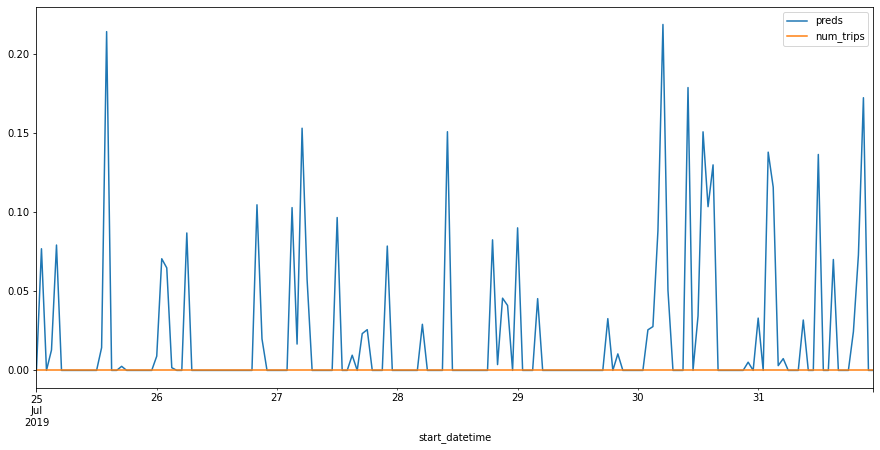

In [19]:
# Plot of min_station
min_station_df.tail(168).plot(x='start_datetime', y=['preds', 'num_trips'], figsize=(15,7))

#### Median Station

In [29]:
preds_median = preds_plot[median_station_index]
preds_median[preds_median < 0] = 0

In [30]:
y_test_median = y_test_plot[median_station_index]

In [31]:
median_station_df = combined_df[combined_df['start_station_id'] == median_station].tail(539)
median_station_df['preds'] = preds_median
median_station_df['y_test'] = y_test_median

In [32]:
median_station_df.rename(columns={"num_trips": "Actual", "preds": "Predicted"}, inplace=True)

In [33]:
median_station_df.tail(168).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168 entries, 99224 to 108075
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   start_datetime           168 non-null    datetime64[ns]
 1   start_station_id         168 non-null    int64         
 2   start_station_longitude  168 non-null    float64       
 3   start_station_latitude   168 non-null    float64       
 4   avg_trip_duration        168 non-null    float64       
 5   day_of_week              168 non-null    int64         
 6   day_of_month             168 non-null    int64         
 7   month                    168 non-null    int64         
 8   hour                     168 non-null    int64         
 9   is_weekend               168 non-null    bool          
 10  avg_daily_wind_speed     168 non-null    float64       
 11  precipitation            168 non-null    float64       
 12  snowfall                 168 

In [34]:
df_plot = median_station_df.tail(168)[["start_datetime", "Actual", "Predicted"]]

In [35]:
df_plot

,start_datetime,Actual,Predicted
99224,2019-07-25 00:00:00,0.0,0.650148
99277,2019-07-25 01:00:00,0.0,0.195876
99330,2019-07-25 02:00:00,0.0,0.182452
99383,2019-07-25 03:00:00,1.0,0.340630
99436,2019-07-25 04:00:00,0.0,0.231882
...,...,...,...
107863,2019-07-31 19:00:00,0.0,0.463681
107916,2019-07-31 20:00:00,3.0,0.521417
107969,2019-07-31 21:00:00,0.0,0.934848
108022,2019-07-31 22:00:00,3.0,0.707866


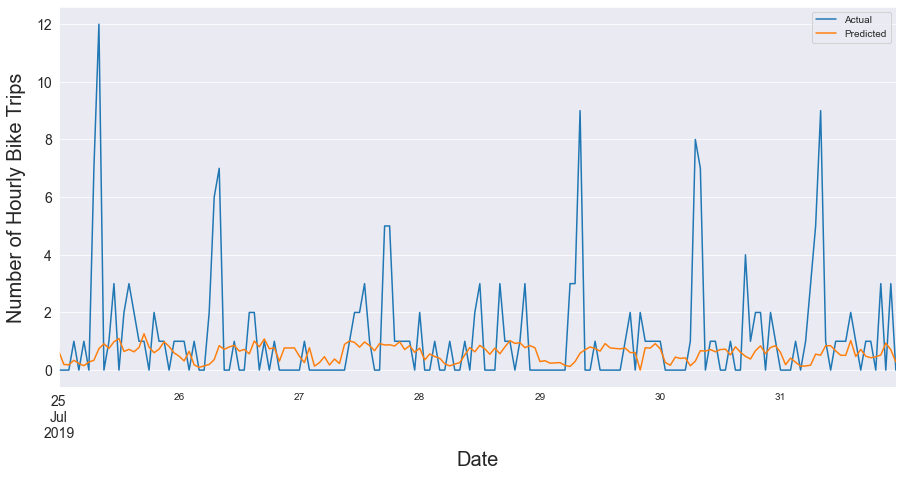

In [37]:
# Plot of median_station
p = df_plot.plot(x='start_datetime', y=['Actual', 'Predicted'], figsize=(15,7))
p.set_xlabel('Date', fontsize=20, labelpad=10)
p.set_ylabel('Number of Hourly Bike Trips', fontsize=20, labelpad=10)
p.tick_params(labelsize=14)

fig = p.get_figure()
fig.savefig('figs/LSTM-median.png', bbox_inches='tight')

In [57]:
median_station_df.tail(168).tail()

,start_datetime,start_station_id,start_station_longitude,start_station_latitude,avg_trip_duration,day_of_week,day_of_month,month,hour,is_weekend,...,day_of_week_cos,day_of_month_sin,day_of_month_cos,month_sin,month_cos,is_am_peak,is_pm_peak,Actual,Predicted,y_test
107863,2019-07-31 19:00:00,3194,-74.067622,40.72534,0.000000,2,31,7,19,True,...,-0.5,-2.449294e-16,1.0,-2.449294e-16,1.0,False,True,0.0,0.585466,1.0
107916,2019-07-31 20:00:00,3194,-74.067622,40.72534,418.666667,2,31,7,20,True,...,-0.5,-2.449294e-16,1.0,-2.449294e-16,1.0,False,False,3.0,0.533642,0.0
107969,2019-07-31 21:00:00,3194,-74.067622,40.72534,0.000000,2,31,7,21,True,...,-0.5,-2.449294e-16,1.0,-2.449294e-16,1.0,False,False,0.0,0.916887,3.0
108022,2019-07-31 22:00:00,3194,-74.067622,40.72534,363.000000,2,31,7,22,True,...,-0.5,-2.449294e-16,1.0,-2.449294e-16,1.0,False,False,3.0,0.438187,0.0
108075,2019-07-31 23:00:00,3194,-74.067622,40.72534,0.000000,2,31,7,23,True,...,-0.5,-2.449294e-16,1.0,-2.449294e-16,1.0,False,False,0.0,0.391991,3.0


#### Max Station

In [29]:
preds_max = preds_plot[max_station_index]
preds_max[preds_max < 0] = 0

In [30]:
y_test_max = y_test_plot[max_station_index]

In [31]:
max_station_df = combined_df[combined_df['start_station_id'] == max_station].tail(539)
max_station_df['preds'] = preds_max
max_station_df['y_test'] = y_test_max

<AxesSubplot:xlabel='start_datetime'>

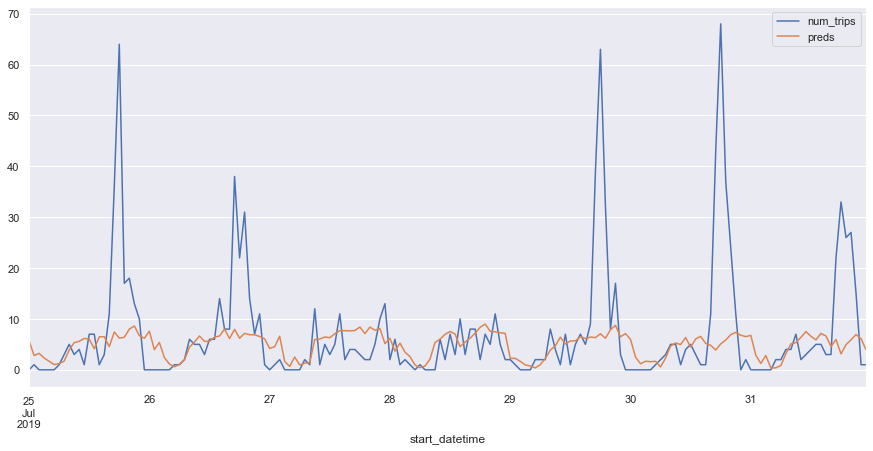

In [32]:
# Plot of median_station
max_station_df.tail(168).plot(x='start_datetime', y=['num_trips', 'preds'], figsize=(15,7))

### Plot Distribution of Errors

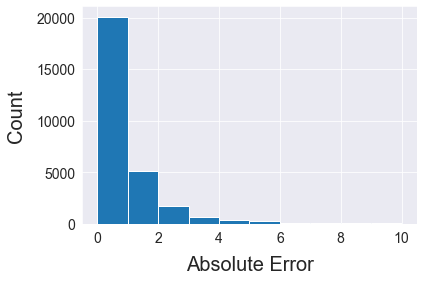

In [38]:
# Plot distribution
plt.hist(np.abs(preds_reshape - y_test_reshape), bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.xlabel('Absolute Error', fontsize=20, labelpad=10)
plt.ylabel('Count', fontsize=20, labelpad=10)
plt.tick_params(labelsize=14)

plt.savefig('figs/LSTM_AbsErrorHist.png', bbox_inches='tight')

In [39]:
# Determine number of predictions with absolute error over 5
error_df = pd.DataFrame(np.abs(preds_reshape - y_test_reshape), columns=['abs_error'])
error_df[error_df['abs_error'] > 5].count()

abs_error    717
dtype: int64

In [40]:
# Determine number of predictions with absolute error over 10
error_df[error_df['abs_error'] > 10].count()

abs_error    195
dtype: int64

In [41]:
# Determine number of predictions with absolute error over 20
error_df[error_df['abs_error'] > 20].count()

abs_error    51
dtype: int64